### Group 28 members:
- Jingze Tian (jingze4)
- Letian Ren (letian2)
- Essam Gouda (egouda)

# Task 2: Classification
- Logistic Regression model for female OR male mosquito = function(weather_features)
- Support Vector Machine model for female OR male mosquito = function(weather_features)
- Random Forest model for female OR male mosquito = function(weather_features)

#### Variations for each model:
- 10-fold cross validation for each model was performed
- ROC curve for each model was plotted

# Imports

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from _datetime import datetime

import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white bg for sns plots
sns.set(style="whitegrid", color_codes=True)

import warnings; warnings.simplefilter('ignore')

# Read csv files (datasets)

In [2]:
weather_data = pd.read_csv('./data/weather_data.csv')
mos_data = pd.read_csv('./data/mosquito_data_new.csv')

In [3]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,09/15/2015 12:00:00 AM,Aedes,vexans,Female,NaN,3,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
1,05/12/1998 12:00:00 AM,Male,UnID,Male,UnID,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
2,08/28/2001 12:00:00 AM,Culex,tarsalis,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
3,08/17/2004 12:00:00 AM,Culex,territans,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
4,05/15/2018 12:00:00 AM,Culiseta,impatiens,Female,NaN,2,Rural-West,NaN,Outer,53.559020,-114.001190,POINT (-114.00119 53.559020000000004)


In [4]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation
0,2018-12-18 16:00:00 MST,1545174000,91.73,99.7,SW,23.0,5.0,NaN,64.0,-7.3,-1.3,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-18 15:00:00 MST,1545170400,91.67,99.7,S,18.0,5.0,NaN,65.0,-6.3,-0.5,-2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,2018-12-18 14:00:00 MST,1545166800,91.67,99.6,S,17.0,5.0,NaN,51.0,-6.5,2.7,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3,2018-12-18 13:00:00 MST,1545163200,91.66,99.6,SE,13.0,2.0,NaN,50.0,-6.4,2.9,NaN,NaN,NaN,3.9,NaN,NaN,NaN,NaN
4,2018-12-18 12:00:00 MST,1545159600,91.75,99.7,NaN,NaN,0.0,NaN,59.0,-6.6,0.5,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN


In [5]:
first_row = {'Trap Date':['05/09/2017 12:00:00 AM'], 'Gender':'Male', 'Count':0}
first_row = pd.DataFrame(first_row)
mos_data = mos_data.append(first_row)

## Select dates range for mosquito data

In [6]:
t_list = []
for i in mos_data['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%m/%d/%Y %H:%M:%S AM")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

mos_data['Trap Date'] = t_list


mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])

############data select#############
start_remove = min(weather_data['date_time_local'])
end_remove = max(weather_data['date_time_local'])
mos_data_1 = mos_data.loc[(mos_data["Trap Date"] >= start_remove) & (mos_data["Trap Date"] <= end_remove) ]
mos_date_start = str(mos_data_1['Trap Date'].dt.date.min())
mos_date_end = str(mos_data_1['Trap Date'].dt.date.max())
mos_date_range = mos_date_start +' to ' + mos_date_end
print("Range of dates in mosquito dataset is {}".format(mos_date_range))

mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])
mos_range = (mos_data['Trap Date'] >= mos_date_start) & (mos_data['Trap Date'] <= mos_date_end)
mos_data = mos_data.loc[mos_range]
mos_data = mos_data.sort_values(by='Trap Date')


mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

Range of dates in mosquito dataset is 2017-05-09 to 2018-09-25


,Count
Trap Date,
2018-06-12,9938


In [7]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,2017-05-09,NaN,NaN,Male,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
6843,2017-05-09,Culiseta,inornata,Female,NaN,2,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
17781,2017-05-09,Culiseta,inornata,Female,NaN,1,Rural-North West,NaN,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)
19436,2017-05-09,Culiseta,alaskaensis,Female,NaN,2,Rural-South West,NaN,Peripheral,53.528587,-113.738070,POINT (-113.7380701 53.5285872)
16953,2017-05-09,Culiseta,inornata,Female,NaN,2,Outer Community-South1,NaN,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)


In [8]:
mos_count.head()

,Count
Trap Date,
2017-05-09,26
2017-05-16,29
2017-05-23,523
2017-05-30,363
2017-06-06,1656


In [9]:
len(mos_count)

41

## Select dates range for weather data

In [10]:
start_date1 = '2017-05-03' #one week before 2017-05-09
end_date1 = '2017-09-26'
start_date2 = '2018-05-09' #one week before 2018-05-15
end_date2 = '2018-09-25'

##############Drop MST###################
weather_data.drop(columns=["visibility", "cloud_cover_4", "cloud_cover_8", "cloud_cover_10", "solar_radiation", "wind_gust", "windchill", "humidex"], inplace=True)
weather_data = weather_data.loc[weather_data['date_time_local'].str.contains('MDT')]


t_list = []
for i in weather_data['date_time_local']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d %H:%M:%S MDT")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

weather_data['date_time_local'] = t_list


weather_data['date_time_local'] = pd.to_datetime(weather_data['date_time_local'])
weather_range1 = (weather_data['date_time_local'] >= start_date1) & (weather_data['date_time_local'] <= end_date1)
weather_data1 = weather_data.loc[weather_range1]
weather_data1 = weather_data1.sort_values(by='date_time_local')


weather_range2 = (weather_data['date_time_local'] >= start_date2) & (weather_data['date_time_local'] <= end_date2)
weather_data2 = weather_data.loc[weather_range2]
weather_data2 = weather_data2.sort_values(by='date_time_local')
weather_data = weather_data1.append(weather_data2)

In [11]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,relative_humidity,dew_point,temperature,health_index
14273,2017-05-03,1493791200,93.91,101.9,SW,21.0,3.0,64.0,0.3,6.6,3.0
14250,2017-05-03,1493874000,93.51,101.4,SW,22.0,7.0,50.0,2.6,12.7,3.7
14251,2017-05-03,1493870400,93.49,101.4,SW,24.0,6.0,48.0,2.0,12.9,3.5
14252,2017-05-03,1493866800,93.44,101.3,WNW,29.0,5.0,34.0,1.0,17.1,3.3
14253,2017-05-03,1493863200,93.38,101.3,W,27.0,7.0,28.0,0.2,18.9,3.3


## Seperate mosquito data by gender

In [12]:
mos_data_male = mos_data.loc[mos_data['Gender'].str.contains('Male')]
mos_data_female = mos_data.loc[mos_data['Gender'].str.contains('Female')]

mos_count_male = mos_data_male.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_male[mos_count_male['Count'] == mos_count_male['Count'].max()]


mos_count_female = mos_data_female.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_female[mos_count_female['Count'] == mos_count_female['Count'].max()]


mos_count_male["Count_female"] = mos_count_female["Count"]
mos_count_male['Gender'] = np.where(mos_count_male["Count"] > mos_count_male["Count_female"], 'Male', 'Female')
#compare count

gender = np.array(mos_count_male['Gender'])

## Grouping both datasets
- For justifications for the methods of grouping the weather data please refer to task 1

#### weather data grouping by days then weekly

In [13]:
weather_data_grouped = weather_data.groupby('date_time_local', as_index=False).agg({
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

287


In [14]:
weather_data_grouped.sort_values('date_time_local', inplace=True)
weather_data_grouped.head(7)

,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-03,93.87,101.50,20.0,7.0,-1.6,18.9,2.8
1,2017-05-04,93.64,101.40,22.0,7.0,1.9,8.4,3.2
2,2017-05-05,92.13,100.25,15.0,13.0,4.6,27.2,2.8
3,2017-05-06,92.68,100.30,28.0,13.0,5.2,14.9,2.4
4,2017-05-07,93.48,101.30,31.0,18.0,-3.0,6.3,2.2
5,2017-05-08,93.54,101.60,31.0,8.0,-4.8,14.0,2.9
6,2017-05-09,93.62,101.60,32.0,7.0,2.1,16.7,2.9


In [15]:
weather_data_grouped = weather_data_grouped.groupby(weather_data_grouped.index // 7).agg({
    'date_time_local': 'last',
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

## NOTE GROUPING DATA BY WEEK LED TO LOWER ACCURACY

41


#### mosquito data grouping by date

In [16]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,2017-05-09,NaN,NaN,Male,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
6843,2017-05-09,Culiseta,inornata,Female,NaN,2,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
17781,2017-05-09,Culiseta,inornata,Female,NaN,1,Rural-North West,NaN,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)
19436,2017-05-09,Culiseta,alaskaensis,Female,NaN,2,Rural-South West,NaN,Peripheral,53.528587,-113.738070,POINT (-113.7380701 53.5285872)
16953,2017-05-09,Culiseta,inornata,Female,NaN,2,Outer Community-South1,NaN,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)


In [17]:
idx = mos_data.groupby(['Trap Date'])['Count'].transform(max) == mos_data['Count']

mos_data_grouped = mos_data[idx]
mos_data_grouped.drop(columns=['IDd', 'Include', 'Latitude', 'Location', 'Longitude','Trap Region'], inplace=True)
mos_data_grouped.head()

,Trap Date,Genus,Specific Epithet,Gender,Count,Comparison Group
19777,2017-05-09,Culiseta,inornata,Female,3,Peripheral
13603,2017-05-09,Culiseta,inornata,Female,3,Core
11069,2017-05-09,Culiseta,inornata,Female,3,Core
19195,2017-05-16,Ochlerotatus,Black legs,Female,13,Core
16171,2017-05-23,Male,UnID,Male,137,Outer


In [18]:
len(mos_data_grouped)

43

#### merging both dataset by date

In [19]:
merged_data = pd.merge(left=mos_data_grouped, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')
merged_data.drop(columns=['date_time_local'], inplace=True)

In [20]:
merged_data.head()

,Trap Date,Genus,Specific Epithet,Gender,Count,Comparison Group,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-09,Culiseta,inornata,Female,3,Peripheral,93.87,101.4,31.0,7.0,5.2,6.3,2.7
1,2017-05-09,Culiseta,inornata,Female,3,Core,93.87,101.4,31.0,7.0,5.2,6.3,2.7
2,2017-05-09,Culiseta,inornata,Female,3,Core,93.87,101.4,31.0,7.0,5.2,6.3,2.7
3,2017-05-16,Ochlerotatus,Black legs,Female,13,Core,92.94,100.9,11.0,12.0,5.3,2.4,2.4
4,2017-05-23,Male,UnID,Male,137,Outer,92.37,101.9,20.0,6.0,5.1,22.9,2.5


In [21]:
merged_data.drop(columns=['Count'], inplace=True)
merged_data.head()

,Trap Date,Genus,Specific Epithet,Gender,Comparison Group,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-09,Culiseta,inornata,Female,Peripheral,93.87,101.4,31.0,7.0,5.2,6.3,2.7
1,2017-05-09,Culiseta,inornata,Female,Core,93.87,101.4,31.0,7.0,5.2,6.3,2.7
2,2017-05-09,Culiseta,inornata,Female,Core,93.87,101.4,31.0,7.0,5.2,6.3,2.7
3,2017-05-16,Ochlerotatus,Black legs,Female,Core,92.94,100.9,11.0,12.0,5.3,2.4,2.4
4,2017-05-23,Male,UnID,Male,Outer,92.37,101.9,20.0,6.0,5.1,22.9,2.5


In [22]:
len(merged_data)

43

In [23]:
merged_data.isnull().sum()

Trap Date           0
Genus               0
Specific Epithet    0
Gender              0
Comparison Group    0
pressure_station    0
pressure_sea        0
wind_dir_10s        0
wind_speed          0
dew_point           0
temperature         0
health_index        0
dtype: int64

In [24]:
merged_data['Gender'].value_counts()

Male      22
Female    21
Name: Gender, dtype: int64

It can be seen that the dataset is balanced.

## ADDING EXTRA FEATURES

isWarm feature if the temperature is more than 20 degrees

In [25]:
merged_data['isWarm'] = np.where(merged_data['temperature'] >= 20, 1, 0)

isWindy feature if the windspeed is more than 25 mph

In [26]:
merged_data['isWindy'] = np.where(merged_data['wind_speed'] >= 25, 1, 0)

Ignore Genus and Specific Epither columns as they are not weather data

In [27]:
# merged_data['Genus'] = merged_data['Genus'].astype('category')
# merged_data['genusCat'] = merged_data['Genus'].cat.codes
# merged_data = pd.concat([merged_data, pd.get_dummies(merged_data['Genus'])], axis=1)
merged_data.drop(columns=['Genus'], inplace=True)

In [28]:
# merged_data['Specific Epithet'] = merged_data['Specific Epithet'].astype('category')
# merged_data['epithetCat'] = merged_data['Specific Epithet'].cat.codes
# merged_data = pd.concat([merged_data, pd.get_dummies(merged_data['Specific Epithet'])], axis=1)
merged_data.drop(columns=['Specific Epithet'], inplace=True)

In [29]:
# merged_data['Comparison Group'] = merged_data['Comparison Group'].astype('category')
# merged_data['compCat'] = merged_data['Comparison Group'].cat.codes
# merged_data = pd.concat([merged_data, pd.get_dummies(merged_data['Comparison Group'])], axis=1)
merged_data.drop(columns=['Comparison Group'], inplace=True)

In [30]:
merged_data['genderCat'] = np.where(merged_data['Gender'] == "Female", 1, 0)
merged_data.drop(columns=["Gender"], inplace=True)

delta_pressure is the difference between the station level pressure and the sea level pressure

In [31]:
merged_data["delta_pressure"] = merged_data.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

In [32]:
merged_data.drop(columns=['Trap Date'], inplace=True)

In [33]:
merged_data.head()

,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index,isWarm,isWindy,genderCat,delta_pressure
0,93.87,101.4,31.0,7.0,5.2,6.3,2.7,0,0,1,-7.53
1,93.87,101.4,31.0,7.0,5.2,6.3,2.7,0,0,1,-7.53
2,93.87,101.4,31.0,7.0,5.2,6.3,2.7,0,0,1,-7.53
3,92.94,100.9,11.0,12.0,5.3,2.4,2.4,0,0,1,-7.96
4,92.37,101.9,20.0,6.0,5.1,22.9,2.5,1,0,0,-9.53


# Classification

## General overview of all available models

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#from xgboost import XGBClassifier, plot_importance 

In [35]:
X = merged_data.loc[:, merged_data.columns != 'genderCat']
y = merged_data['genderCat']

In [36]:
npX = np.array(X).copy()
npy = np.array(y).copy()

In [37]:
clf_rf = RandomForestClassifier()
clf_et = ExtraTreesClassifier()
clf_bc = BaggingClassifier()
clf_ada = AdaBoostClassifier()
clf_dt = DecisionTreeClassifier()
#clf_xg = XGBClassifier()
clf_lr = LogisticRegression()
clf_svm = SVC()

In [38]:
#Classifiers = ['RandomForest','ExtraTrees','Bagging','AdaBoost','DecisionTree','XGBoost','SVM']
Classifiers = ['RandomForest','ExtraTrees','Bagging','AdaBoost','DecisionTree','SVM']
scores = []
#models = [clf_rf, clf_et, clf_bc, clf_ada, clf_dt, clf_xg, clf_svm]
models = [clf_rf, clf_et, clf_bc, clf_ada, clf_dt, clf_svm]
for model in models:
    score = cross_val_score(model, npX, npy, scoring = 'accuracy', cv = 10, n_jobs = 1).mean()
    scores.append(score)

In [39]:
mode = pd.DataFrame(scores, index = Classifiers, columns = ['score']).sort_values(by = 'score',
             ascending = False)
mode

,score
DecisionTree,0.560
Bagging,0.555
AdaBoost,0.530
RandomForest,0.495
SVM,0.470
ExtraTrees,0.465


## Logistic Regression

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [41]:
X = merged_data.loc[:, merged_data.columns != 'genderCat']
y = merged_data['genderCat']

### Feature Selection

#### Recursive feature elimination

By assiging weights to features and eliminating the features by recursively training a base model, the best features are selected.

In [42]:
model_lr = LogisticRegression()
rfe = RFE(model_lr, 8)
rfe = rfe.fit(X, y)
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['pressure_station', 'pressure_sea', 'wind_speed', 'dew_point', 'temperature', 'health_index', 'isWarm', 'delta_pressure']


#### Recursive feature elimination and cross-validation
Performs RFE with a 10-fold cross validation loop to find the best number of features and the selected ones

In [43]:
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)
print("Best number of features: %d" % rfecv.n_features_)
print('Selected features are : %s' % list(X.columns[rfecv.support_]))

Best number of features: 3
Selected features are : ['health_index', 'isWarm', 'delta_pressure']


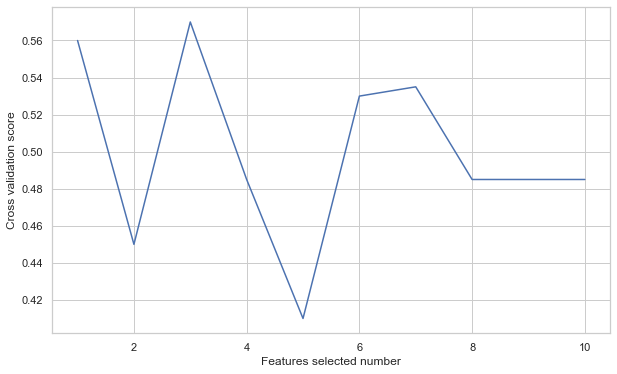

In [44]:
plt.figure(figsize=(10,6))
plt.xlabel("Features selected number")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#### Correlation matrix on selected features

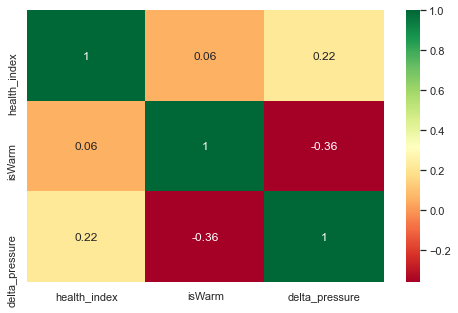

In [45]:
Selected_features = list(X.columns[rfecv.support_])

X_log = X[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X_log.corr(), annot=True, cmap="RdYlGn")
plt.show()

### Model Evaluation

Using train-test split and cross validation score and also by using the whole dataset.

LogisticRegression accuracy = 0.778
LogisticRegression log_loss = 0.614
LogisticRegression auc = 0.750


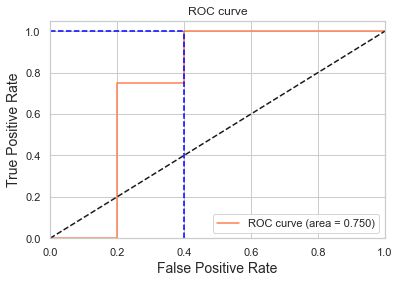

Threshold = 0.432 guarantees a sensitivity = 1.000 , specificity = 0.600 and false positive rate = 40.00%.


In [46]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.2, random_state=2)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_prob)
print(logreg.__class__.__name__+" accuracy = %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss = %2.3f" % log_loss(y_test, y_pred_prob))
print(logreg.__class__.__name__+" auc = %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) #index of sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

print("Threshold = %.3f " % thr[idx] + "guarantees a sensitivity = %.3f " % tpr[idx] +  
      ", specificity = %.3f" % (1-fpr[idx]) + 
      " and false positive rate = %.2f%%." % (np.array(fpr[idx])*100))

10-fold cross validation

In [47]:
logreg = LogisticRegression()
scores_accuracy = cross_val_score(logreg, X_log, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X_log, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X_log, y, cv=10, scoring='roc_auc')

print(logreg.__class__.__name__+" average accuracy = %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss = %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc = %2.3f" % scores_auc.mean())

LogisticRegression average accuracy = 0.615
LogisticRegression average log_loss = 0.713
LogisticRegression average auc = 0.625


In [48]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X_log, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

LogisticRegression average accuracy: 0.615 (+/-0.326)
LogisticRegression average log_loss: 0.713 (+/-0.230)
LogisticRegression average auc: 0.625 (+/-0.321)


In [49]:
results

{'fit_time': array([0.01800108, 0.00800037, 0.00800037, 0.00700068, 0.00800061,
        0.00900054, 0.00800037, 0.00800061, 0.00800061, 0.00900054]),
 'score_time': array([0.02100134, 0.01000071, 0.00700045, 0.00600004, 0.00600028,
        0.00700045, 0.00600028, 0.00600028, 0.00700045, 0.00600004]),
 'test_accuracy': array([1.  , 0.4 , 1.  , 0.25, 0.5 , 1.  , 0.5 , 0.75, 0.75, 0.  ]),
 'test_neg_log_loss': array([-0.53408115, -0.66816259, -0.60856128, -0.91182024, -0.72731558,
        -0.44687616, -0.68157669, -0.64235901, -0.59930946, -1.30917007]),
 'test_roc_auc': array([1.  , 0.5 , 1.  , 0.25, 0.5 , 1.  , 0.5 , 0.75, 0.75, 0.  ])}

GridSearchCV method by testing different params

best params: LogisticRegression(C=0.70001)
best params: {'C': 0.70001}
best score: 0.62


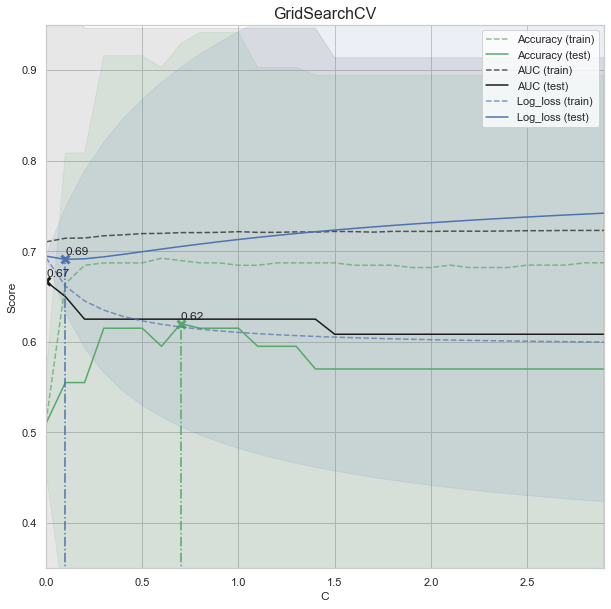

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_log, y)
results = gs.cv_results_

print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV",fontsize=16)

plt.xlabel("C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.35, 0.95)


X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        

    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)


    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

best params: Pipeline(steps=[('scale', StandardScaler(with_mean=False, with_std=False)),
                ('clf', LogisticRegression(C=0.50001))])
best params: {'clf__C': 0.50001}
best score: 0.6277777777777778


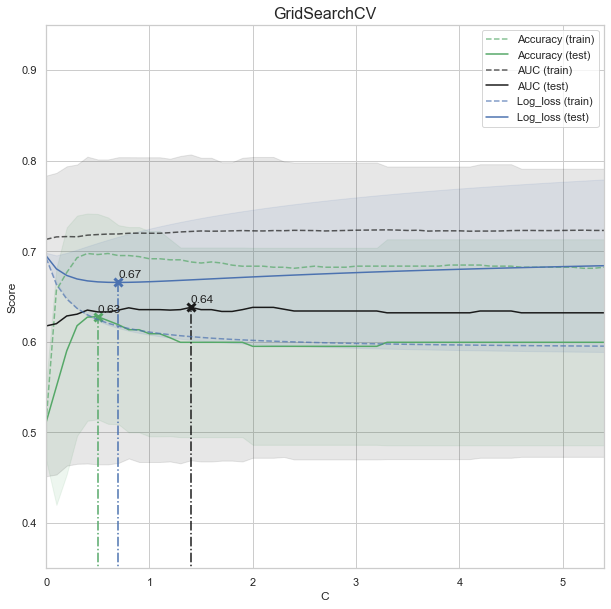

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

C = np.arange(1e-05, 5.5, 0.1)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
log_reg = LogisticRegression()


std_scale = StandardScaler(with_mean=False, with_std=False)

n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=2)


log_clf_pipe = Pipeline(steps=[('scale',std_scale), ('clf',log_reg)])

log_clf = GridSearchCV(estimator=log_clf_pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')

log_clf.fit(X_log, y)
results = log_clf.cv_results_

print("best params: " + str(log_clf.best_estimator_))
print("best params: " + str(log_clf.best_params_))
print('best score:', log_clf.best_score_)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV",fontsize=16)

plt.xlabel("C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, C.max()) 
ax.set_ylim(0.35, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_clf__C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

## SVM

In [52]:
parameters_svm = {'C':[0.9,0.01],'kernel':['rbf','linear'], 'gamma':[0,0.1,'auto'], 'probability':[True],
                  'random_state':[0,7,16],'decision_function_shape':['ovo','ovr'],'degree':[3,4,10]}

In [53]:
X = merged_data.loc[:, merged_data.columns != 'genderCat']
y = merged_data['genderCat']

### Model Evaluation

train-test split

SVC accuracy = 0.333
SVC log_loss = 0.694
SVC auc = 0.375


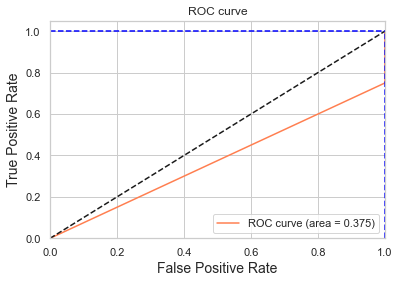

Threshold = 0.495 guarantees a sensitivity = 1.000 , specificity = 0.000 and false positive rate = 100.00%.


In [54]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

sv = SVC(probability=True)
sv.fit(X_train, y_train)
y_pred = sv.predict(X_test)
y_pred_prob = sv.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_prob)
print(sv.__class__.__name__+" accuracy = %2.3f" % accuracy_score(y_test, y_pred))
print(sv.__class__.__name__+" log_loss = %2.3f" % log_loss(y_test, y_pred_prob))
print(sv.__class__.__name__+" auc = %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) #index of sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

print("Threshold = %.3f " % thr[idx] + "guarantees a sensitivity = %.3f " % tpr[idx] +  
      ", specificity = %.3f" % (1-fpr[idx]) + 
      " and false positive rate = %.2f%%." % (np.array(fpr[idx])*100))

10-fold cross validation

In [55]:
sv = SVC(probability=True)
scores_accuracy = cross_val_score(sv, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(sv, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(sv, X, y, cv=10, scoring='roc_auc')

print(sv.__class__.__name__+" average accuracy = %2.3f" % scores_accuracy.mean())
print(sv.__class__.__name__+" average log_loss = %2.3f" % -scores_log_loss.mean())
print(sv.__class__.__name__+" average auc = %2.3f" % scores_auc.mean())

SVC average accuracy = 0.470
SVC average log_loss = 0.701
SVC average auc = 0.250


In [56]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = SVC(probability=True)

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

SVC average accuracy: 0.470 (+/-0.046)
SVC average log_loss: 0.701 (+/-0.023)
SVC average auc: 0.250 (+/-0.253)


GrtidSearchCV

best params: SVC(C=0.9, decision_function_shape='ovo', gamma='auto', probability=True,
    random_state=0)
best params: {'C': 0.9, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True, 'random_state': 0}
best score: 0.5700000000000001


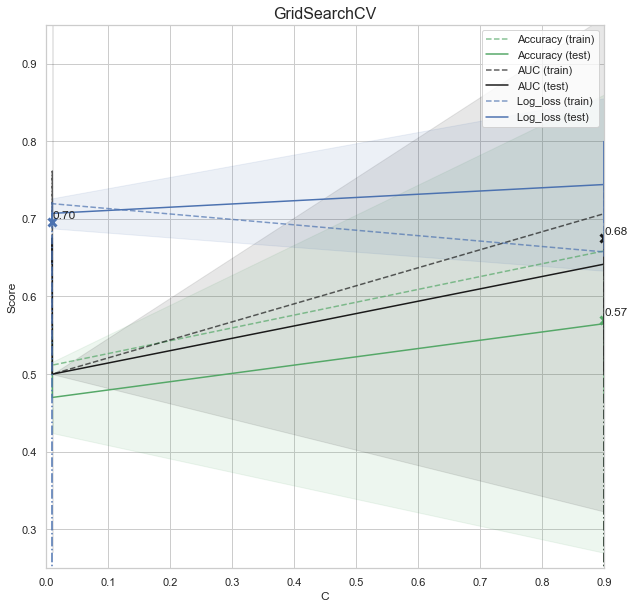

In [57]:
from sklearn.model_selection import GridSearchCV

scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

modelCV = SVC()

gs = GridSearchCV(modelCV, return_train_score=True,
                  param_grid=parameters_svm, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_log, y)
results = gs.cv_results_

print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV",fontsize=16)

plt.xlabel("C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, 0.9) 
ax.set_ylim(0.25, 0.95)


X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        

    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)


    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

## Random Forests

In [58]:
X = merged_data.loc[:, merged_data.columns != 'genderCat']
y = merged_data['genderCat']

### Feature Selection

#### Recursive feature elimination

In [59]:
model_rf = RandomForestClassifier()
rfe = RFE(model_rf, 8)
rfe = rfe.fit(X, y)
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['pressure_station', 'pressure_sea', 'wind_dir_10s', 'wind_speed', 'dew_point', 'temperature', 'health_index', 'delta_pressure']


#### Recursive feature elimination and cross-validation


In [60]:
rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)
print("Best number of features: %d" % rfecv.n_features_)
print('Selected features are : %s' % list(X.columns[rfecv.support_]))

Best number of features: 10
Selected features are : ['pressure_station', 'pressure_sea', 'wind_dir_10s', 'wind_speed', 'dew_point', 'temperature', 'health_index', 'isWarm', 'isWindy', 'delta_pressure']


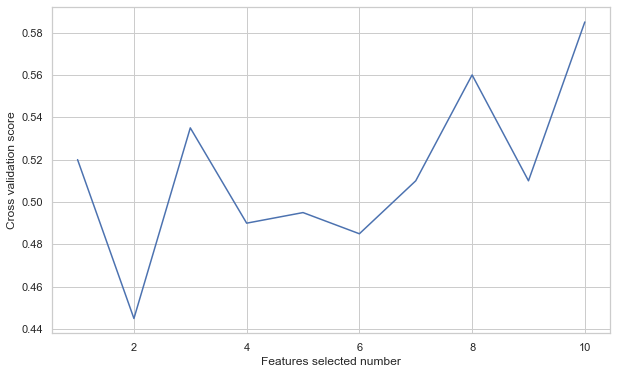

In [61]:
plt.figure(figsize=(10,6))
plt.xlabel("Features selected number")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#### Correlation matrix on selected features

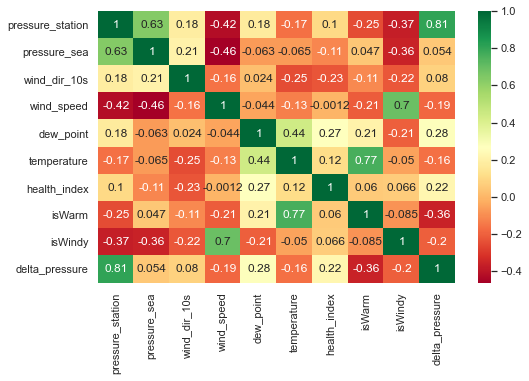

In [62]:
Selected_features = list(X.columns[rfecv.support_])

X_rf = X[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X_rf.corr(), annot=True, cmap="RdYlGn")
plt.show()

### Model Evaluation

In [63]:
parameters_rf = {'n_estimators': [100,50],
                 'n_jobs': [1], 'min_samples_leaf': [2,4,], 'random_state':[1,7,], 
                 'min_samples_split':[2,6,], 'oob_score': [True,False],
                 'criterion': ['gini',  'entropy'], 'warm_start': [True,False]}

RandomForestClassifier accuracy = 0.778
RandomForestClassifier log_loss = 0.376
RandomForestClassifier auc = 1.000


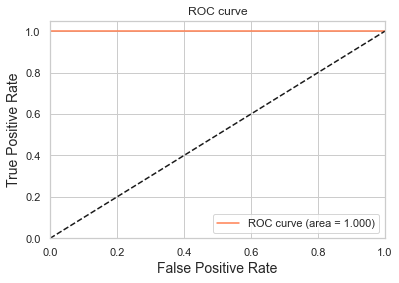

Threshold = 0.760 guarantees a sensitivity = 1.000 , specificity = 1.000 and false positive rate = 0.00%.


In [64]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_prob)
print(rf.__class__.__name__+" accuracy = %2.3f" % accuracy_score(y_test, y_pred))
print(rf.__class__.__name__+" log_loss = %2.3f" % log_loss(y_test, y_pred_prob))
print(rf.__class__.__name__+" auc = %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) #index of sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

print("Threshold = %.3f " % thr[idx] + "guarantees a sensitivity = %.3f " % tpr[idx] +  
      ", specificity = %.3f" % (1-fpr[idx]) + 
      " and false positive rate = %.2f%%." % (np.array(fpr[idx])*100))

10-fold cross validation

In [65]:
rf = RandomForestClassifier()
scores_accuracy = cross_val_score(rf, X_rf, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(rf, X_rf, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(rf, X_rf, y, cv=10, scoring='roc_auc')

print(rf.__class__.__name__+" average accuracy = %2.3f" % scores_accuracy.mean())
print(rf.__class__.__name__+" average log_loss = %2.3f" % -scores_log_loss.mean())
print(rf.__class__.__name__+" average auc = %2.3f" % scores_auc.mean())

RandomForestClassifier average accuracy = 0.555
RandomForestClassifier average log_loss = 0.791
RandomForestClassifier average auc = 0.517


In [66]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = RandomForestClassifier()

results = cross_validate(modelCV, X_rf, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

RandomForestClassifier average accuracy: 0.555 (+/-0.305)
RandomForestClassifier average log_loss: 0.786 (+/-0.258)
RandomForestClassifier average auc: 0.508 (+/-0.330)


In [68]:
results

{'fit_time': array([0.18901062, 0.13000751, 0.12400699, 0.15600896, 0.12100697,
        0.13000774, 0.12600732, 0.12800717, 0.11900663, 0.12300682]),
 'score_time': array([0.02000141, 0.01900101, 0.02200127, 0.0210011 , 0.0210011 ,
        0.02900171, 0.0210011 , 0.02100134, 0.02000117, 0.02100134]),
 'test_accuracy': array([0.4 , 0.4 , 1.  , 0.25, 0.75, 0.5 , 0.5 , 0.75, 1.  , 0.  ]),
 'test_neg_log_loss': array([-1.1133335 , -0.9078161 , -0.44713525, -0.84458515, -0.79040185,
        -0.61124837, -1.02649904, -0.55487736, -0.40139634, -1.15777589]),
 'test_roc_auc': array([0.5       , 0.33333333, 1.        , 0.5       , 0.5       ,
        0.5       , 0.        , 0.75      , 1.        , 0.        ])}

GridSearchCV

In [69]:
modelCV = RandomForestClassifier()

grid = GridSearchCV(estimator = modelCV, param_grid = parameters_rf, cv = 10, 
                    scoring = 'accuracy', n_jobs=None)
grid.fit(X_rf,y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 6], 'n_estimators': [100, 50],
                         'n_jobs': [1], 'oob_score': [True, False],
                         'random_state': [1, 7], 'warm_start': [True, False]},
             scoring='accuracy')

## Plot boundries Random forest
On multiple runs the number of features for the forest change to more than 2 so we need to add a dimensiality reduction in order to plot the boandries for these cases 

In [70]:
from matplotlib.colors import ListedColormap

def boundaries(model, heading, best_params, X_train, X_test, y_train, y_test):
    Model = model(**best_params)
    Model.fit(X_train, y_train)

    X_set, y_set = np.concatenate([X_train, X_test], axis = 0), np.concatenate([y_train, y_test], axis = 0)
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                             np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))

    #plt.figure(figsize = [15,16])
    plt.contourf(X1, X2, Model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                     alpha = 0.5, cmap = ListedColormap(('k', 'blue')))
    
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())

    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
    plt.xticks(fontsize = 3)
    plt.yticks(fontsize = 3)

Apply PCA dimensionality reduction to reduce the features to 2D in order to visualize

In [71]:
from sklearn.decomposition import PCA

if rfecv.n_features_ > 2:
    X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size = .2)
    X_train = PCA(n_components = 2).fit_transform(X_train)
    X_test  = PCA(n_components=  2).fit_transform(X_test) 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


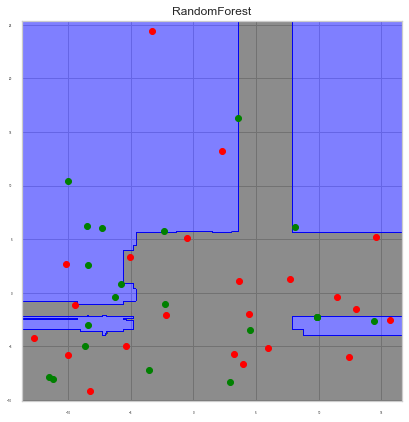

In [72]:
fig = plt.figure(figsize=[15,7])

ax = plt.subplot(1,2,2)
plt.title('RandomForest')
boundaries(RandomForestClassifier, 'Random Forest', grid.best_estimator_.get_params(), X_train, X_test, y_train, y_test)

## t-test on models

In [73]:
pip install mlxtend

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [74]:
from mlxtend.evaluate import paired_ttest_kfold_cv
t, p = paired_ttest_kfold_cv(rfe, sv, npX, npy, random_seed=1)
print('t = %.3f' %t)
print('p = %.3f' %p)

t = 4.206
p = 0.002


# Conclusion
From 10-fold cross validation it can be seen that the RandomForest Classifier was the best when it comes to splitting the dataset, but Logisitc Regression pipeline had the best accuracy on training the whole dataset.